# 10 Academy: Artificial Intelligence Mastery


# Correlation Analysis 
General objective:
How sentiment analysis(emotional tone of the headlines) affect stock price movement 

Ethel Cherotaw


Step 1: Prepare the Data

In [53]:
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

filtered_data =pd.read_csv(r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\filtered_analyst_ratings.csv') 
aapl_data = pd.read_csv(r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\yfinance_data\AAPL_historical_data.csv')
amzn_data = pd.read_csv(r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\yfinance_data\AMZN_historical_data.csv')
goog_data = pd.read_csv(r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\yfinance_data\GOOG_historical_data.csv')
meta_data = pd.read_csv(r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\yfinance_data\META_historical_data.csv')
msft_data = pd.read_csv(r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\yfinance_data\MSFT_historical_data.csv')
nvda_data = pd.read_csv(r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\yfinance_data\NVDA_historical_data.csv')
tsla_data = pd.read_csv(r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\yfinance_data\TSLA_historical_data.csv') 

# Checking the date format 
print("Filtered Analyst Ratings Data(Stocks.AAPL,AMZN,GOOG,NVDA, and TESLA):")
filtered_data.head()

print("\nAAPL Historical Data:")
print(aapl_data.head())

Filtered Analyst Ratings Data(Stocks.AAPL,AMZN,GOOG,NVDA, and TESLA):

AAPL Historical Data:
         Date      Open      High       Low     Close  Adj Close     Volume  \
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943  469033600   
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781  175884800   
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898  105728000   
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   86441600   
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   73449600   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  


# Data Cleansing 

Step 2: Ensure the date format in the headlines data matches the stock data.

Maintaining uniform date formatting is essential for precise time-based analyses and comparisons with other time series datasets. Ensuring a consistent date format allows for accurate temporal comparisons and proper assessment of trends and patterns. Furthermore, enhancing readability by eliminating unnecessary or redundant columns and renaming columns can also help improve clarity and reduce errors in the dataset. Making sure that only data that is relevant is included is important for maintaining the integrity of correlation calculations and data analysis, resulting in more accurate and practical insights. 

Date Parsing: 

In [54]:
def convert_date_format(date_str):
    if '-' in date_str:  # If the date contains a '-' (indicating yyyy-mm-dd format)
        date = pd.to_datetime(date_str, errors='coerce')  # Convert to datetime
        return date.strftime('%m/%d/%Y') if not pd.isnull(date) else np.nan
    elif '/' in date_str:  # If the date contains a '/' (indicating mm/dd/yyyy format)
        date = pd.to_datetime(date_str, format='%m/%d/%Y %H:%M', errors='coerce')  # Convert to datetime
        return date.strftime('%m/%d/%Y') if not pd.isnull(date) else np.nan
    else:
        return np.nan

# Load the filtered data
filtered_data = pd.read_csv(r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\filtered_analyst_ratings.csv')

filtered_data['converted_date'] = filtered_data['date'].apply(convert_date_format)

filtered_data = filtered_data.drop(columns=['date'])

filtered_data = filtered_data.rename(columns={'converted_date': 'Date'})

unnamed_columns = [col for col in filtered_data.columns if 'Unnamed' in col]
filtered_data = filtered_data.drop(columns=unnamed_columns)

#filtered_data.to_csv(r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\filtered_dates.csv', index=False)

print(filtered_data)

                                               headline  \
0     Tech Stocks And FAANGS Strong Again To Start D...   
1         10 Biggest Price Target Changes For Wednesday   
2     Benzinga Pro's Top 5 Stocks To Watch For Wed.,...   
3     Deutsche Bank Maintains Buy on Apple, Raises P...   
4     Apple To Let Users Trade In Their Mac Computer...   
...                                                 ...   
6934   Electrek.Co Tweet: Tesla's head of Europe is out   
6935  Tesla's Q2 Delivery Number Could Cause A Big Move   
6936  'Tesla Electric Airplane? Elon Musk sees elect...   
6937  UPDATE: JMP Reiterates Outperform, $347 Target...   
6938  Tesla shares are trading higher after JMP Secu...   

                                                    url          publisher  \
0     https://www.benzinga.com/government/20/06/1622...         JJ Kinahan   
1     https://www.benzinga.com/analyst-ratings/price...         Lisa Levin   
2     https://www.benzinga.com/short-sellers/20/06/1...  

Step 3: Filtering the data

Aligning data based on dates and concentrating on closing prices are crucial phases in data cleaning to maintain consistency and comparability of datasets. By eliminating unnecessary columns and filtering by the same dates, inconsistencies are eliminated and only the most pertinent data is analyzed. This procedure is crucial for ensuring the consistency and correctness of data, especially when conducting correlation analysis. Cleaning the data helps ensure that any discovered insights or relationships are founded on dependable and consistent information. 

In [55]:

def align_and_save_closing_prices( filtered_data, historical_paths, output_dir):
   
    filtered_data['Date'] = pd.to_datetime(filtered_data['Date'])

    # Create a directory to save aligned data if it does not exist
    os.makedirs(output_dir, exist_ok=True)

    def align_data(stock_symbol, filtered_data, stock_data):
        """Filter and merge data for each stock symbol, keeping only the closing price and adding stock symbol."""
        filtered_stock = filtered_data[filtered_data['stock'] == stock_symbol]
        merged_stock = pd.merge(filtered_stock, stock_data[['Date', 'Close']], left_on='Date', right_on='Date', how='inner')
        merged_stock['stock'] = stock_symbol  # Add the stock symbol column
        return merged_stock[['Date', 'headline', 'url', 'publisher', 'Close', 'stock']]

    for symbol, path in historical_paths.items():
        # Load the historical stock data
        stock_data = pd.read_csv(path)
        stock_data['Date'] = pd.to_datetime(stock_data['Date'])
        
        # Align and save the data
        aligned_data = align_data(symbol, filtered_data, stock_data)
        output_file = os.path.join(output_dir, f'final_aligned_{symbol.lower()}_closing_data.csv')
        aligned_data.to_csv(output_file, index=False)
       
historical_stock_paths = {
    'AAPL': r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\yfinance_data\AAPL_historical_data.csv',
    'AMZN': r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\yfinance_data\AMZN_historical_data.csv',
    'GOOG': r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\yfinance_data\GOOG_historical_data.csv',
    'META': r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\yfinance_data\META_historical_data.csv',
    'MSFT': r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\yfinance_data\MSFT_historical_data.csv',
    'NVDA': r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\yfinance_data\NVDA_historical_data.csv',
    'TSLA': r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\yfinance_data\TSLA_historical_data.csv'
}
output_directory = r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\final_aligned_closing_data'

# Call the function
align_and_save_closing_prices( filtered_data,historical_stock_paths, output_directory)


# Sentiment Analysis

Step 4: Sentimental analysis for each stocks 

In order to investigate the connection between market sentiment and stock performance, match up past stock closing prices with relevant financial news headlines. Use the VADER sentiment analysis tool to evaluate the sentiment of every headline, classifying it as positive, neutral, or negative. Visualize the sentiment score distribution for various stocks by creating a subplot grid for a thorough comparison. This method assists in identifying possible correlations between the sentiment conveyed in the news and future fluctuations in stock prices, providing valuable guidance for making strategic decisions in financial markets. 

Sentiment has the greatest influence on the closing price as it represents the market's ultimate verdict at the end of the day. Adjusted Close becomes more advantageous when taking into consideration dividends and stock splits. 

Sentiment counts for AAPL:
sentiment_category
Neutral     178
Positive    143
Negative     94
Name: count, dtype: int64


Sentiment counts for AMZN:
sentiment_category
Positive    133
Neutral      88
Negative     44
Name: count, dtype: int64


Sentiment counts for GOOG:
sentiment_category
Neutral     547
Positive    410
Negative    211
Name: count, dtype: int64


Sentiment counts for NVDA:
sentiment_category
Neutral     1563
Positive    1043
Negative     464
Name: count, dtype: int64


Sentiment counts for TSLA:
sentiment_category
Neutral     901
Positive    611
Negative    273
Name: count, dtype: int64




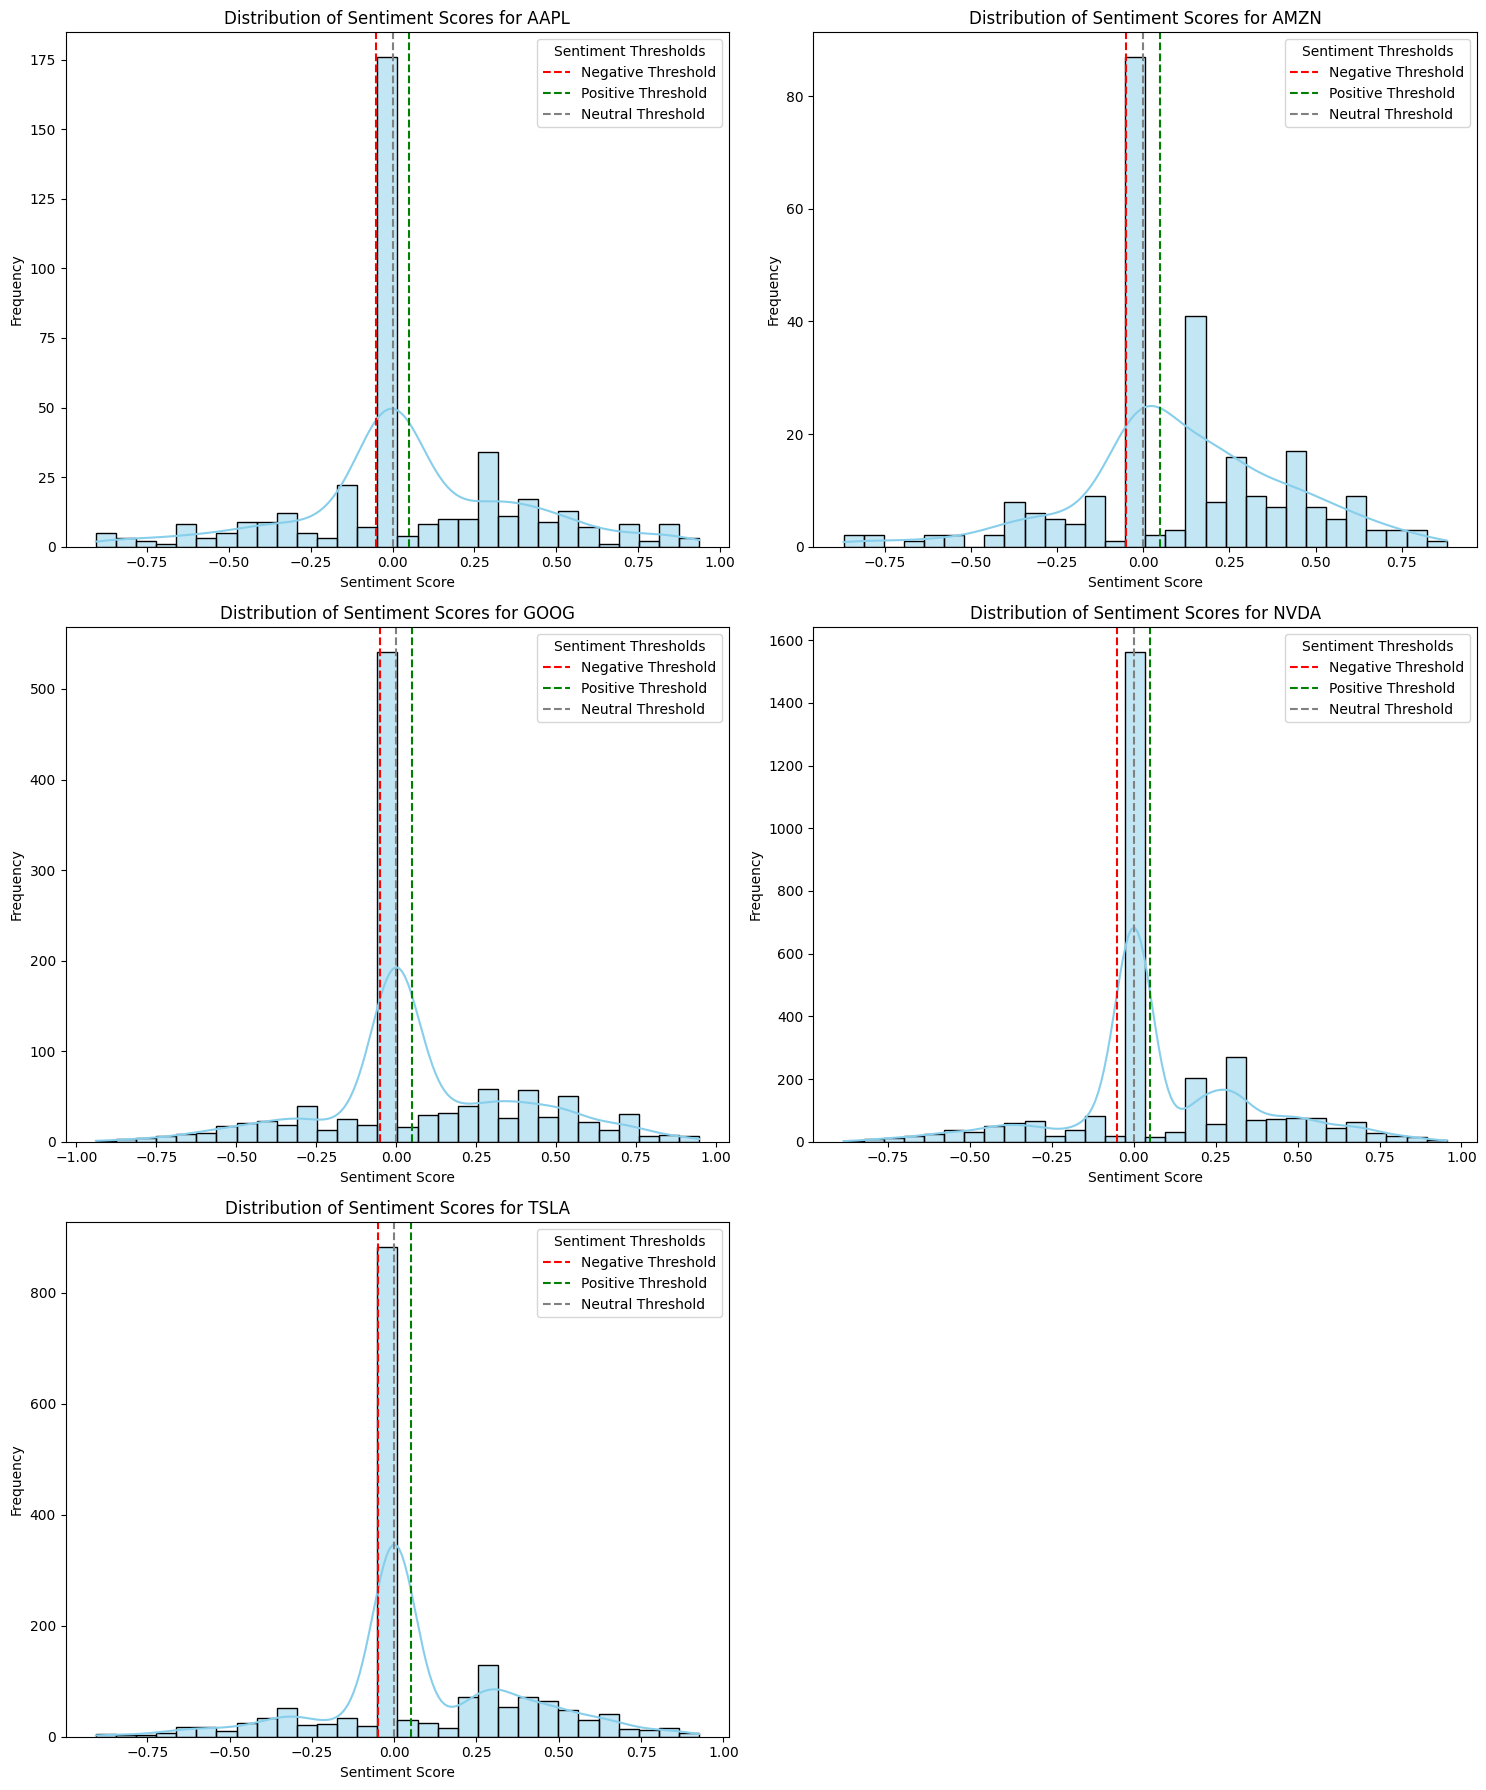

In [57]:
sid = SentimentIntensityAnalyzer()

# Function to analyze sentiment of a given text
def analyze_sentiment(text):
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores['compound']

# Function to categorize sentiment based on the score
def categorize_sentiment(score, positive_threshold=0.05, negative_threshold=-0.05):
    if score >= positive_threshold:
        return 'Positive'
    elif score <= negative_threshold:
        return 'Negative'
    else:
        return 'Neutral'

def align_and_save_closing_prices_with_sentiment(filtered_data, historical_paths, output_dir):
    filtered_data['Date'] = pd.to_datetime(filtered_data['Date'])
    os.makedirs(output_dir, exist_ok=True)

    fig, axes = plt.subplots(3, 2, figsize=(15, 18))  # Create 3x2 subplots grid
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

    for i, (symbol, path) in enumerate(historical_paths.items()):
        # Load the historical stock data
        stock_data = pd.read_csv(path)
        stock_data['Date'] = pd.to_datetime(stock_data['Date'])
        
        # Filter and merge data for each stock symbol
        filtered_stock = filtered_data[filtered_data['stock'] == symbol]
        merged_stock = pd.merge(filtered_stock, stock_data[['Date', 'Close']], left_on='Date', right_on='Date', how='inner')
        merged_stock['stock'] = symbol
        
        # Perform sentiment analysis
        merged_stock['sentiment'] = merged_stock['headline'].apply(analyze_sentiment)
        merged_stock['sentiment_category'] = merged_stock['sentiment'].apply(categorize_sentiment)

        # Save the results to a CSV file
        output_file = os.path.join(output_dir, f'final_aligned_{symbol.lower()}_closing_data_with_sentiment.csv')
        merged_stock.to_csv(output_file, index=False)

        # Plotting the distribution of sentiment scores
        sns.histplot(merged_stock['sentiment'], bins=30, kde=True, color='skyblue', ax=axes[i])

        # Adding vertical lines for sentiment boundaries
        axes[i].axvline(x=-0.05, color='red', linestyle='--', label='Negative Threshold')
        axes[i].axvline(x=0.05, color='green', linestyle='--', label='Positive Threshold')
        axes[i].axvline(x=0, color='gray', linestyle='--', label='Neutral Threshold')

        axes[i].set_title(f'Distribution of Sentiment Scores for {symbol}')
        axes[i].set_xlabel('Sentiment Score')
        axes[i].set_ylabel('Frequency')
        axes[i].legend(title='Sentiment Thresholds')

        # Print the counts of each sentiment category for quick reference
        sentiment_counts = merged_stock['sentiment_category'].value_counts()
        print(f'Sentiment counts for {symbol}:')
        print(sentiment_counts)
        print("\n")

    # Remove the empty subplot if there are fewer than 6 plots
    if len(historical_paths) < 6:
        fig.delaxes(axes[-1])

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

# Define your file paths and output directory
historical_stock_paths = {
    'AAPL': r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\yfinance_data\AAPL_historical_data.csv',
    'AMZN': r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\yfinance_data\AMZN_historical_data.csv',
    'GOOG': r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\yfinance_data\GOOG_historical_data.csv',
    'NVDA': r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\yfinance_data\NVDA_historical_data.csv',
    'TSLA': r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\yfinance_data\TSLA_historical_data.csv'
}
output_directory = r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\final_aligned_closing_data_with_sentiment'

# Call the function
align_and_save_closing_prices_with_sentiment(filtered_data, historical_stock_paths, output_directory)



The visual displays histograms depicting how sentiment scores are spread among five key stocks: AAPL (Apple), AMZN (Amazon), GOOG (Google), NVDA (NVIDIA), and TSLA (Tesla). Every histogram displays the occurrence of sentiment scores, spanning from negative to positive, where the x-axis exhibits the sentiment scores and the y-axis depicts their frequency. The histograms have dashed lines that show sentiment thresholds: red for negative, green for positive, and black for neutral sentiment. 

The distributions indicate that AAPL and GOOG stocks have a variety of sentiments leaning towards positivity, while NVDA and TSLA stocks are mostly neutral. AMZN's sentiment scores are closely grouped around neutrality with a slight favor towards positivity and less extreme fluctuations. This examination is crucial in deciphering the distribution of sentiment among these stocks and reveal connections between market sentiment and stock price changes. 

# Correlation Analysis 

Some stocks' sentiment score distributions, such as those of NVDA and TSLA, show an essentially symmetrical form with the neutral threshold at its center. This balance, especially when the data is aggregated over multiple days, suggests a distribution that is rather close to normal. In terms of other equities, like GOOG, AMZN, and AAPL, the overall trend points to a distribution that is comparable to normal, even though there may be some skewness or outliers.

It makes sense to look into if there is a linear relationship between changes in sentiment scores and changes in stock returns given this approximate normal distribution. Since the Pearson correlation assesses both the strength and direction of the linear relationship between two variables, it is a useful tool for this kind of work.

The most effective use of Pearson correlation is when the variables follow a normal distribution, a common assumption for daily returns and average sentiment scores, particularly once they have been aggregated. Hence, it is suitable to utilize Pearson correlation to examine the connection between sentiment and stock returns in this scenario.


Filtered Date Results:
AAPL - Filtered Date Range: 2020-03-09 00:00:00 to 2020-06-10 00:00:00
AAPL - Full Date Range: 2020-03-09 00:00:00 to 2020-06-10 00:00:00
---
AMZN - Filtered Date Range: 2020-03-09 00:00:00 to 2020-06-10 00:00:00
AMZN - Full Date Range: 2020-04-27 00:00:00 to 2020-06-10 00:00:00
---
GOOG - Filtered Date Range: 2020-03-09 00:00:00 to 2020-06-10 00:00:00
GOOG - Full Date Range: 2018-11-13 00:00:00 to 2020-06-10 00:00:00
---
NVDA - Filtered Date Range: 2020-03-09 00:00:00 to 2020-06-10 00:00:00
NVDA - Full Date Range: 2011-03-03 00:00:00 to 2020-06-10 00:00:00
---
TSLA - Filtered Date Range: 2020-03-09 00:00:00 to 2020-06-10 00:00:00
TSLA - Full Date Range: 2019-07-01 00:00:00 to 2020-06-10 00:00:00
---


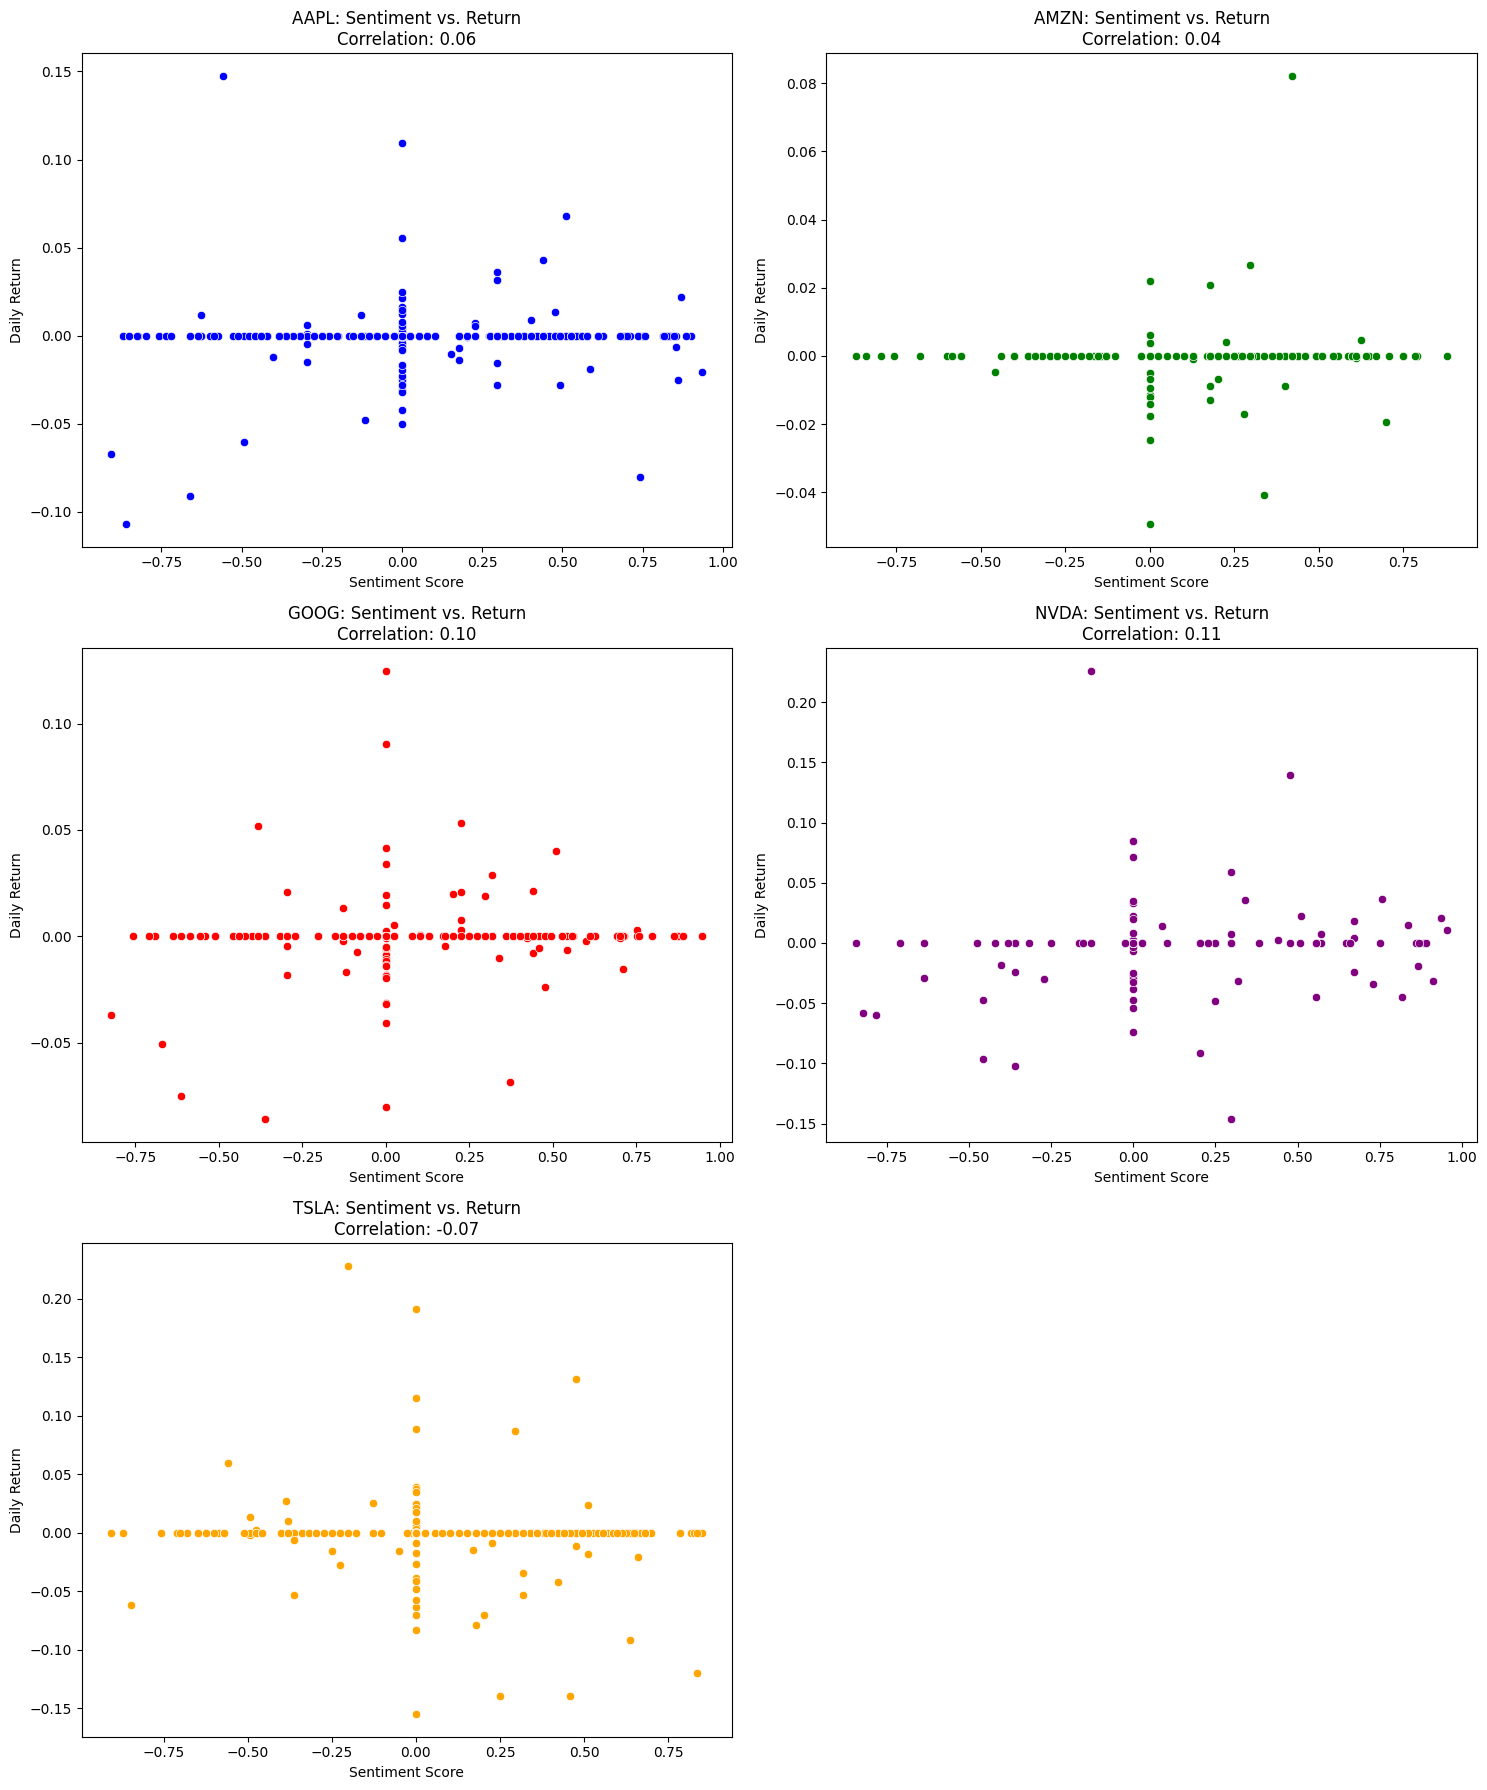

Pearson Correlations between Daily Returns and Sentiment Scores:
AAPL: 0.06 - Very weak positive or no association
AMZN: 0.04 - Very weak positive or no association
GOOG: 0.10 - Very weak positive or no association
NVDA: 0.11 - Very weak positive or no association
TSLA: -0.07 - Very weak negative or no association
Unfiltered Date Results:
AAPL - Full Date Range: 2020-03-09 00:00:00 to 2020-06-10 00:00:00
---
AMZN - Full Date Range: 2020-04-27 00:00:00 to 2020-06-10 00:00:00
---
GOOG - Full Date Range: 2018-11-13 00:00:00 to 2020-06-10 00:00:00
---
NVDA - Full Date Range: 2011-03-03 00:00:00 to 2020-06-10 00:00:00
---
TSLA - Full Date Range: 2019-07-01 00:00:00 to 2020-06-10 00:00:00
---


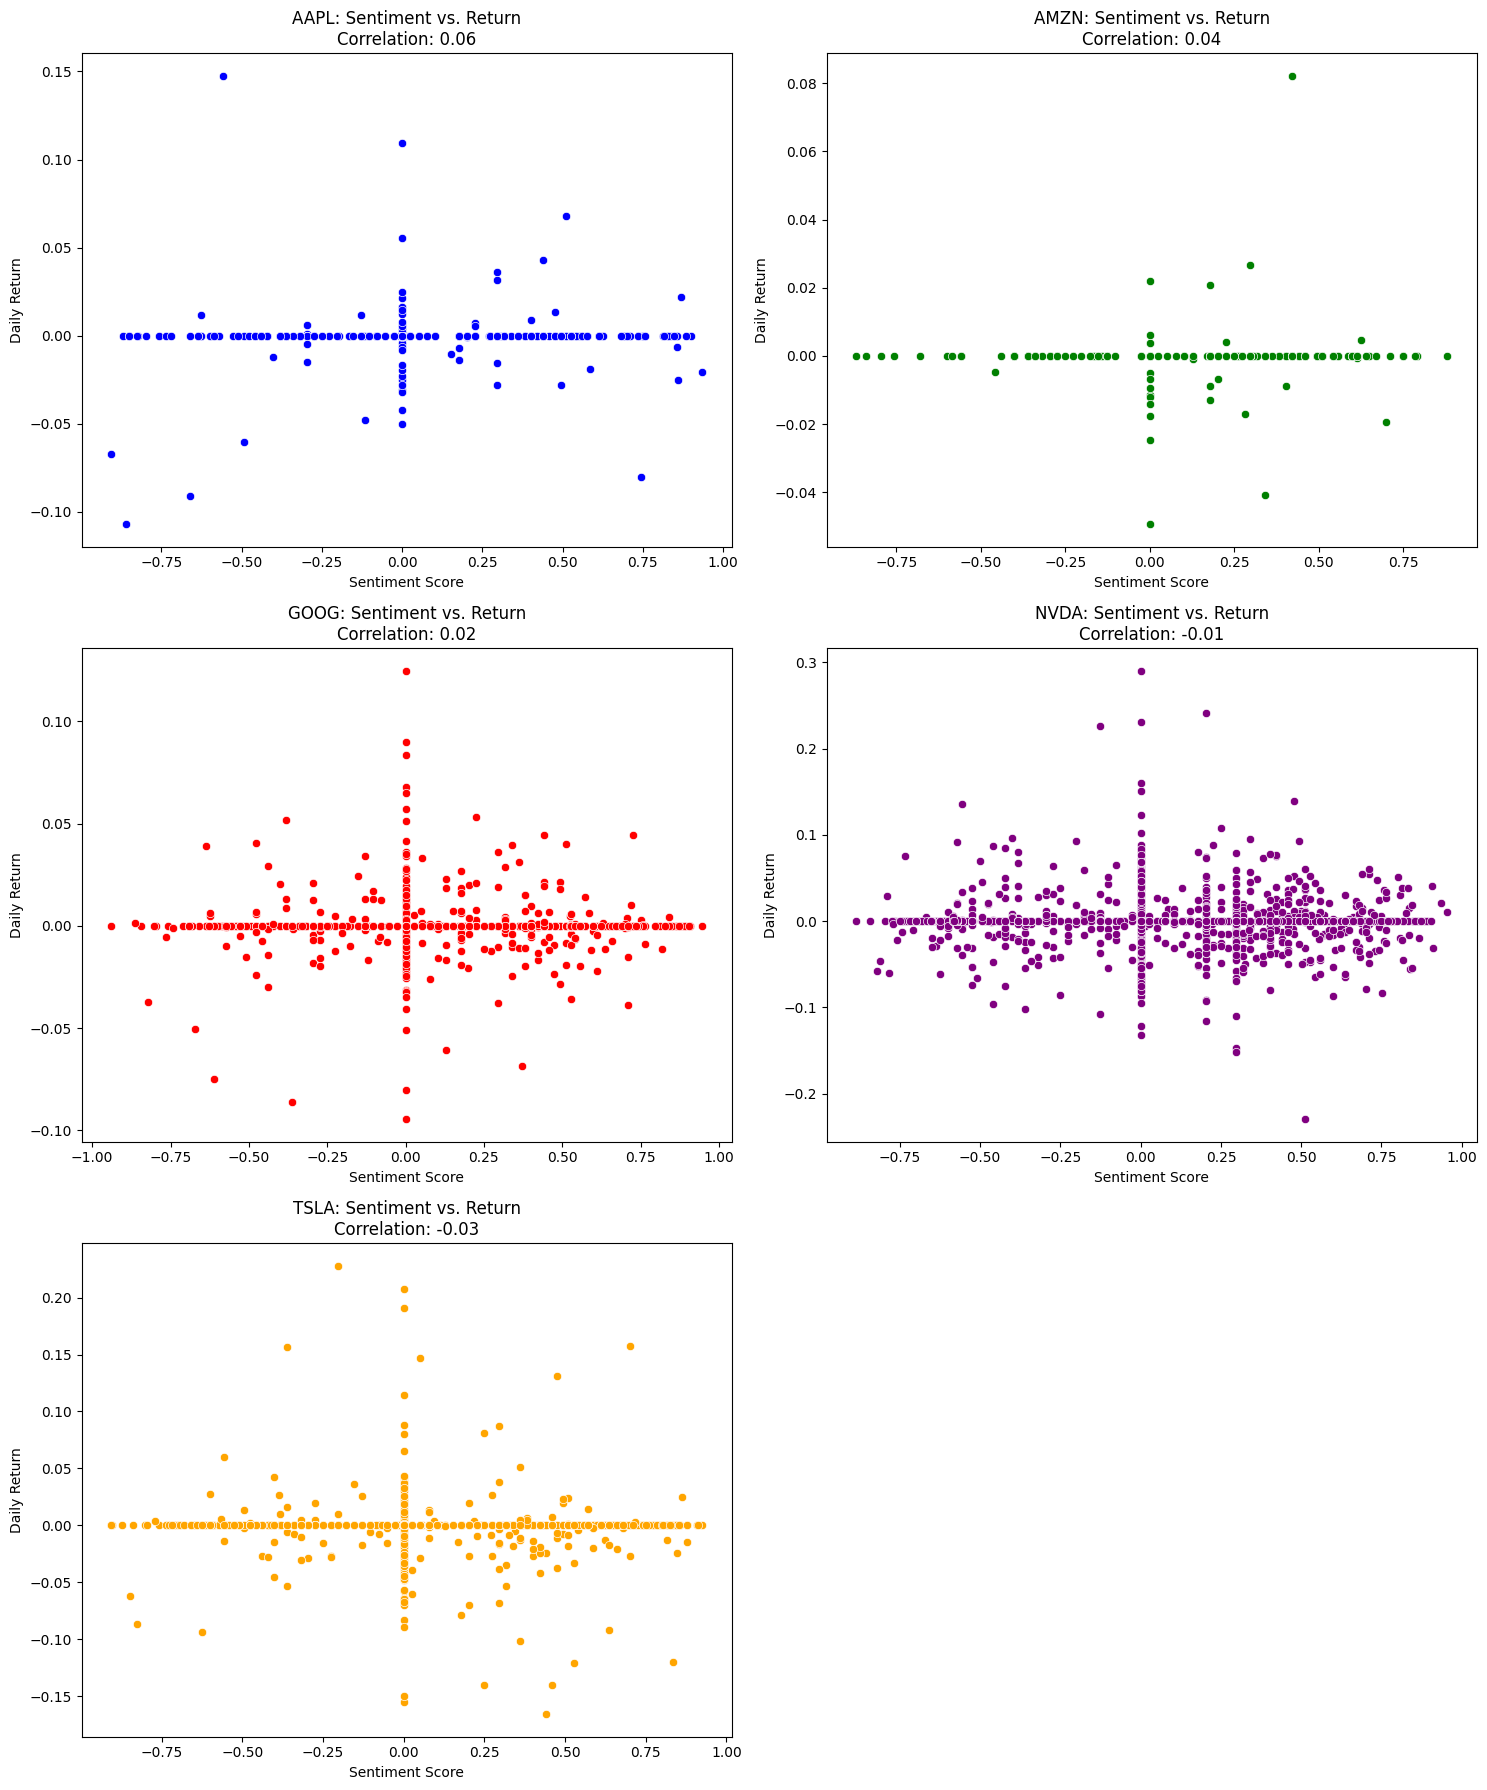

Pearson Correlations between Daily Returns and Sentiment Scores:
AAPL: 0.06 - Very weak positive or no association
AMZN: 0.04 - Very weak positive or no association
GOOG: 0.02 - Very weak positive or no association
NVDA: -0.01 - Very weak negative or no association
TSLA: -0.03 - Very weak negative or no association


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the paths to the aligned data CSV files
aligned_data_paths = {
    'AAPL': r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\final_aligned_closing_data_with_sentiment\final_aligned_aapl_closing_data_with_sentiment.csv',
    'AMZN': r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\final_aligned_closing_data_with_sentiment\final_aligned_amzn_closing_data_with_sentiment.csv',
    'GOOG': r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\final_aligned_closing_data_with_sentiment\final_aligned_goog_closing_data_with_sentiment.csv',
    'NVDA': r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\final_aligned_closing_data_with_sentiment\final_aligned_nvda_closing_data_with_sentiment.csv',
    'TSLA': r'C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\final_aligned_closing_data_with_sentiment\final_aligned_tsla_closing_data_with_sentiment.csv'
}

# Define the start and end dates for filtered analysis
start_date_filtered = pd.to_datetime('2020-03-09')
end_date_filtered = pd.to_datetime('2020-06-10')

def process_data(data, filter_dates=None):
    df = data.copy()
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Convert to datetime format
    
    if filter_dates:
        start_date, end_date = filter_dates
        df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]  # Filter by date range
    
    df['Return'] = df['Close'].pct_change()  # Calculate daily returns
    df.dropna(subset=['Return', 'sentiment'], inplace=True)  # Drop rows with NaN values
    
    return df

def get_date_range(data):
    df = data.copy()
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    start_date = df['Date'].min()
    end_date = df['Date'].max()
    return start_date, end_date

def get_correlation_interpretation(correlation):
    """ Return the interpretation of the correlation coefficient. """
    if correlation == 1.0:
        return "Perfect positive association"
    elif 0.8 <= correlation < 1.0:
        return "Very strong positive association"
    elif 0.6 <= correlation < 0.8:
        return "Strong positive association"
    elif 0.4 <= correlation < 0.6:
        return "Moderate positive association"
    elif 0.2 <= correlation < 0.4:
        return "Weak positive association"
    elif 0.0 <= correlation < 0.2:
        return "Very weak positive or no association"
    elif -0.2 < correlation <= 0.0:
        return "Very weak negative or no association"
    elif -0.4 < correlation <= -0.2:
        return "Weak negative association"
    elif -0.6 < correlation <= -0.4:
        return "Moderate negative association"
    elif -0.8 < correlation <= -0.6:
        return "Strong negative association"
    elif correlation <= -0.8:
        return "Very strong negative association"
    else:
        return "Invalid correlation coefficient"

def plot_and_calculate_correlations(data, filter_dates=None):
    # Process data
    processed_data = {}
    for symbol, path in aligned_data_paths.items():
        df = pd.read_csv(path)
        if filter_dates:
            processed_data[symbol] = process_data(df, filter_dates)
        else:
            start_date, end_date = get_date_range(df)
            processed_data[symbol] = process_data(df, (start_date, end_date))

    # Define custom colors for each stock
    colors = {
        'AAPL': 'blue',
        'AMZN': 'green',
        'GOOG': 'red',
        'NVDA': 'purple',
        'TSLA': 'orange'
    }

    # Set up the plotting grid
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

    # Plot scatter plots and calculate correlations
    correlations = {}
    for i, (symbol, df) in enumerate(processed_data.items()):
        # Calculate Pearson correlation
        correlation = df['Return'].corr(df['sentiment'])
        correlations[symbol] = correlation

        # Scatter plot with custom color
        sns.scatterplot(x='sentiment', y='Return', data=df, ax=axes[i], color=colors[symbol])
        axes[i].set_title(f'{symbol}: Sentiment vs. Return\nCorrelation: {correlation:.2f}')
        axes[i].set_xlabel('Sentiment Score')
        axes[i].set_ylabel('Daily Return')

        # Print start and end dates for each stock
        if filter_dates:
            print(f'{symbol} - Filtered Date Range: {filter_dates[0]} to {filter_dates[1]}')
        start_date, end_date = get_date_range(pd.read_csv(aligned_data_paths[symbol]))
        print(f'{symbol} - Full Date Range: {start_date} to {end_date}')
        print('---')

    # Remove the empty subplot if there are fewer than 6 plots
    if len(processed_data) < 6:
        fig.delaxes(axes[len(processed_data)])

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

    # Print correlations with interpretation
    print("Pearson Correlations between Daily Returns and Sentiment Scores:")
    for symbol, corr in correlations.items():
        interpretation = get_correlation_interpretation(corr)
        print(f"{symbol}: {corr:.2f} - {interpretation}")

# Plot and calculate correlations for filtered data
print("Filtered Date Results:")
plot_and_calculate_correlations(aligned_data, filter_dates=(start_date_filtered, end_date_filtered))

# Plot and calculate correlations for unfiltered data using date range from the data
print("Unfiltered Date Results:")
plot_and_calculate_correlations(aligned_data)


The scatter plots illustrate the relationship between sentiment scores (x-axis) and daily returns (y-axis) for different stocks, including AAPL, AMZN, GOOG, NVDA, and TSLA. The correlation values, such as 0.06 for AAPL and 0.04 for AMZN, reflect the degree of linear relationship between sentiment scores and daily returns for each stock. 




These correlations are all close to zero, ranging between -0.07 and 0.11, indicating that there is no strong linear relationship between sentiment scores and daily returns for any of the stocks analyzed. This suggests that changes in sentiment scores do not consistently predict changes in daily returns. 

The scatter plots also show a wide dispersion of data points without a clear trend, further supporting the conclusion that sentiment scores and daily returns are not  strongly correlated. The majority of sentiment scores are categorized as neutral across all stocks: AAPL has 178 neutral, 143 positive, and 94 negative; AMZN has 88 neutral, 133 positive, and 44 negative; GOOG has 547 neutral, 410 positive, and 211 negative; NVDA has 1563 neutral, 1043 positive, and 464 negative; TSLA has 901 neutral, 611 positive, and 273 negative. With most sentiment scores being neutral, we might expect daily returns during those times to exhibit lower volatility or smaller price changes, as neutral sentiment suggests a lack of new, impactful information that could drive stock prices up or down. This indicates a market consensus that there is no substantial new information or events affecting the stocks, leading to daily returns that are more likely to be small or close to zero, reflecting a stable or low volatility environment. Thus, sentiment analysis may have limited utility in predicting significant stock price movements during periods dominated by neutral 

# Reference 
1. https://sphweb.bumc.bu.edu/otlt/MPH-Modules/PH717-QuantCore/PH717-Module9-Correlation-Regression/PH717-Module9-Correlation-Regression4.html
2. https://statisticsbyjim.com/basics/correlations/
3. https://study.com/learn/lesson/correlation-coefficient-interpretation.html
4. https://study.com/learn/lesson/correlation-coefficient-interpretation.html
5. https://www.youtube.com/watch?v=G5FkaxWBtkM